In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10, CIFAR100
from torchvision.utils import make_grid
from torchvision import transforms
import torchvision.transforms.functional as F
from PIL import Image

from CLA.utils.data_utils import ImageNet100
cifar10 = CIFAR10(root='data', train=True, transform=transforms.ToTensor())
cifar100 = CIFAR100(root='data', train=True, transform=transforms.ToTensor())
imagenet = ImageNet100(root='data', train=True, transform=transforms.ToTensor())

In [173]:
import os
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

embedding_layer = 'projector'
datasets = ['cifar10', 'cifar100', 'imagenet']
log_dirs = {
    'cifar10': 'unbalanced', # this was not actually done on unbalanced cifar10. The log directory name was simply not updated
    'cifar100': 'check_to_cifar10',
    'imagenet': 'unbalanced' # this was not actually done on unbalanced cifar10. The log directory name was simply not updated
}
exp_names = {
    'cifar10': 'default',
    'cifar100': 'default',
    'imagenet': 'default'
}

train_embeddings = {}
train_targets = {}
test_embeddings = {}
test_targets = {}
embedding_norms = {}
test_embedding_norms = {}
knn_classifiers = {}

print('Training nearest neighbor classifiers on the following model/dataset latent spaces...')
for model_str in ['simclr', 'simsiam']:
    train_embeddings[model_str] = {}
    train_targets[model_str] = {}
    test_embeddings[model_str] = {}
    test_targets[model_str] = {}
    embedding_norms[model_str] = {}
    test_embedding_norms[model_str] = {}
    knn_classifiers[model_str] = {}
    
    # Load all embeddings
    # These were produced using the model_comparisons.py file to train models.
    # We then ran the trained models on the various datasets and saved off the embeddings.
    for dataset in datasets:
        print(model_str, dataset)
        embeddings_dir = os.path.join(os.getcwd(), 'outputs', dataset, model_str, log_dirs[dataset], exp_names[dataset], 'ablations')
        
        train_embeddings[model_str][dataset] = np.squeeze(np.load(os.path.join(embeddings_dir, 'train_embeddings.npy'), allow_pickle=True)[()][embedding_layer])
        train_targets[model_str][dataset] = np.squeeze(np.load(os.path.join(embeddings_dir, 'train_targets.npy'), allow_pickle=True)[()])
        
        test_embeddings[model_str][dataset] = np.squeeze(np.load(os.path.join(embeddings_dir, 'test_embeddings.npy'), allow_pickle=True)[()][embedding_layer])
        test_targets[model_str][dataset] = np.squeeze(np.load(os.path.join(embeddings_dir, 'test_targets.npy'), allow_pickle=True)[()])
    
        embedding_norms[model_str][dataset] = np.sqrt(np.sum(np.square(train_embeddings[model_str][dataset]), axis=-1))
        test_embedding_norms[model_str][dataset] = np.sqrt(np.sum(np.square(test_embeddings[model_str][dataset]), axis=-1))
        normed_embeds = train_embeddings[model_str][dataset]/np.expand_dims(embedding_norms[model_str][dataset], -1)

        neigh = KNeighborsClassifier(n_neighbors=10)
        neigh.fit(normed_embeds, train_targets[model_str][dataset])
        knn_classifiers[model_str][dataset] = neigh


Training nearest neighbor classifiers on the following model/dataset latent spaces...
simclr cifar10
simclr cifar100
simclr imagenet
simsiam cifar10
simsiam cifar100
simsiam imagenet


In [142]:
from tqdm import tqdm
accuracies = {}
counts = {}
norm_step = 0.05
norm_ranges = np.arange(0, 1, norm_step)

print('Identifying knn accuracies for different model/dataset combinations as a function of embedding norm')
for model_str in ['simclr', 'simsiam']:
    accuracies[model_str] = {}
    counts[model_str] = {}
    for dataset in datasets:
        print(model_str, dataset)
        min_norm = np.min(embedding_norms[model_str][dataset])
        instance_norms = embedding_norms[model_str][dataset] - min_norm
        
        max_norm = np.max(instance_norms)
        instance_norms /= max_norm
        
        accuracies[model_str][dataset] = np.zeros(len(norm_ranges))
        counts[model_str][dataset] = np.zeros(len(norm_ranges))

        for i, norm_bound in tqdm(enumerate(norm_ranges), total=len(norm_ranges)):
            range_inds = np.where(np.logical_and(instance_norms > norm_bound, instance_norms < norm_bound + norm_step))[0]
            counts[model_str][dataset][i] = len(range_inds)
            if len(range_inds) == 0:
                accuracies[model_str][dataset][i] = -1
                continue
            range_samples = train_embeddings[model_str][dataset][range_inds] / np.expand_dims(embedding_norms[model_str][dataset], -1)[range_inds]
            range_targets = train_targets[model_str][dataset][range_inds]
        
            range_preds = knn_classifiers[model_str][dataset].predict(range_samples)
            accuracy = np.sum(range_preds == range_targets) / len(range_targets)
            accuracies[model_str][dataset][i] = accuracy

Identifying knn accuracies for different model/dataset combinations as a function of embedding norm
simclr cifar10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.00it/s]


simclr cifar100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.74it/s]


simclr imagenet


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.73it/s]


simsiam cifar10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:35<00:00,  1.77s/it]


simsiam cifar100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:35<00:00,  1.77s/it]


simsiam imagenet


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:07<00:00,  6.36s/it]


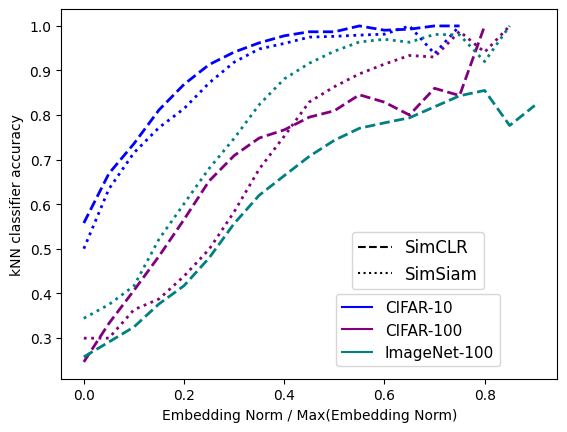

In [145]:
import matplotlib.pyplot as plt
colors = {'cifar10': 'blue', 'cifar100': 'purple', 'imagenet': 'teal'}
linestyles = {'simclr': 'dashed', 'simsiam': 'dotted'}

for model_str in ['simclr', 'simsiam']:
    for dataset in datasets:
        accs = accuracies[model_str][dataset]
        inds = np.where(counts[model_str][dataset] >= 10)[0]
        plt.plot(norm_ranges[inds], accs[inds], color=colors[dataset], linestyle=linestyles[model_str], linewidth=2)


plt.ylabel('kNN classifier accuracy')
plt.xlabel('Embedding Norm / Max(Embedding Norm)')
plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

dataset_name_dict = {'cifar10': 'CIFAR-10', 'cifar100': 'CIFAR-100', 'imagenet': 'ImageNet-100'}
dataset_patches = []
dataset_names = []
for dataset in datasets:
    dataset_patches.append(plt.plot([], [], color=colors[dataset])[0])
    dataset_names.append(dataset_name_dict[dataset])
model_patches = []
for model_str in ['simclr', 'simsiam']:
    model_patches.append(plt.plot([], [], color='black', linestyle=linestyles[model_str])[0])

dataset_legend = plt.legend(dataset_patches, dataset_names, fontsize=11, bbox_to_anchor=(0.6, 0.05, 0.3, 0.2), loc='best')
plt.legend(model_patches, ['SimCLR', 'SimSiam'], fontsize=12, bbox_to_anchor=(0.57, 0.22, 0.3, 0.2), loc='best')
plt.gca().add_artist(dataset_legend)
plt.show()

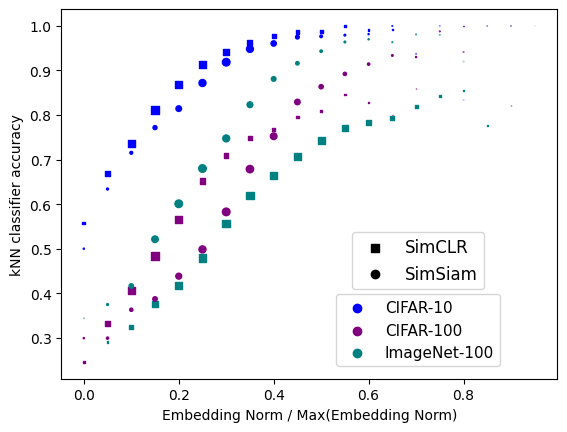

In [146]:
markers = {'simclr': 's', 'simsiam': 'o'}
for model_str in ['simclr', 'simsiam']:
    for dataset in datasets:
        accs = accuracies[model_str][dataset]
        inds = np.where(accs != -1)[0]
        normed_counts = counts[model_str][dataset] / np.max(counts[model_str][dataset])
        plt.scatter(
            norm_ranges[inds],
            accs[inds],
            color=colors[dataset],
            marker=markers[model_str],
            s=normed_counts[inds] * 30
        )


plt.ylabel('kNN classifier accuracy')
plt.xlabel('Embedding Norm / Max(Embedding Norm)')
plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

dataset_name_dict = {'cifar10': 'CIFAR-10', 'cifar100': 'CIFAR-100', 'imagenet': 'ImageNet-100'}
dataset_patches = []
dataset_names = []
for dataset in datasets:
    dataset_patches.append(plt.scatter([], [], color=colors[dataset]))
    dataset_names.append(dataset_name_dict[dataset])
model_patches = []
for model_str in ['simclr', 'simsiam']:
    model_patches.append(plt.scatter([], [], color='black', marker=markers[model_str]))

dataset_legend = plt.legend(dataset_patches, dataset_names, fontsize=11, bbox_to_anchor=(0.6, 0.05, 0.3, 0.2), loc='best')
plt.legend(model_patches, ['SimCLR', 'SimSiam'], fontsize=12, bbox_to_anchor=(0.57, 0.22, 0.3, 0.2), loc='best')
plt.gca().add_artist(dataset_legend)
plt.show()

In [152]:
### Download CIFAR-10N dataset from https://github.com/UCSC-REAL/cifar-10-100n/blob/main/data/CIFAR-10_human.pt
# These should be placed in the `data` directory
import torch

aggre_accuracies = {}
aggre_sdevs = {}
aggre_counts = {}

# CIFAR10-N noisy labels are called "aggre_label" whereas CIFAR100-N noisy labels are called "noisy_label"
label_mapper = {'cifar10': 'aggre_label', 'cifar100': 'noisy_label'}

norm_range = np.arange(0, 1, 0.05)
for model_str in ['simclr', 'simsiam']:
    aggre_accuracies[model_str] = {}
    aggre_sdevs[model_str] = {}
    aggre_counts[model_str] = {}
    
    for dataset in ['cifar10', 'cifar100']:
        cifar_N_file = torch.load('./data/{}_human.pt'.format(dataset_name_dict[dataset]))
        clean_label = cifar_N_file['clean_label']
        aggre_label = cifar_N_file[label_mapper[dataset]]

        min_norm = np.min(embedding_norms[model_str][dataset])
        instance_norms = embedding_norms[model_str][dataset] - min_norm
        max_norm = np.max(instance_norms)
        instance_norms /= max_norm
        
        aggre_accuracies[model_str][dataset] = np.zeros(len(norm_range))
        aggre_sdevs[model_str][dataset] = np.zeros(len(norm_range))
        aggre_counts[model_str][dataset] = np.zeros(len(norm_range))
        
        for i, norm_bound in enumerate(norm_range):
            range_inds = np.where(
                np.logical_and(
                    instance_norms > norm_bound,
                    instance_norms < norm_bound + norm_step
                ))[0]
            range_samples = train_embeddings[model_str][dataset][range_inds] / np.expand_dims(embedding_norms[model_str][dataset], -1)[range_inds]
            if len(range_samples) == 0:
                aggre_counts[model_str][dataset][i] = 0
                aggre_accuracies[model_str][dataset][i] = -1
                aggre_sdevs[model_str][dataset][i] = -1
                continue
            aggre_counts[model_str][dataset][i] = len(range_samples)
            
            aggre_agreement = clean_label[range_inds] == aggre_label[range_inds]
            aggre_accuracies[model_str][dataset][i] = np.mean(aggre_agreement)
            aggre_sdevs[model_str][dataset][i] = np.std(aggre_agreement)

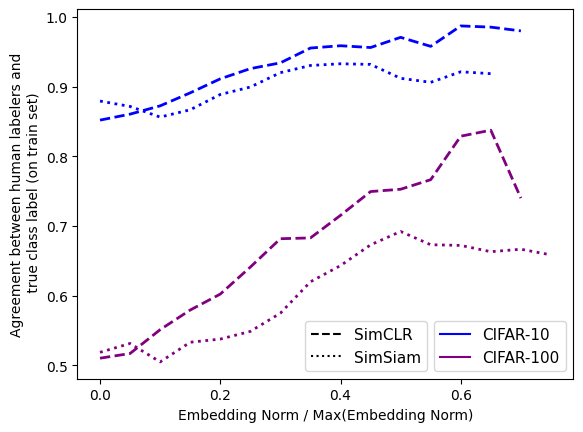

In [192]:
markers = {'simclr': 's', 'simsiam': 'o'}
for model_str in ['simclr', 'simsiam']:
    for dataset in ['cifar10', 'cifar100']:
        inds = np.where(aggre_counts[model_str][dataset] >= 50)[0]
        plt.plot(
            norm_range[inds],
            aggre_accuracies[model_str][dataset][inds],
            color=colors[dataset],
            linestyle=linestyles[model_str],
            linewidth=2
        )
        # plt.fill_between(
        #     norm_range[inds],
        #     aggre_accuracies[model_str][dataset][inds] - aggre_sdevs[model_str][dataset][inds],
        #     aggre_accuracies[model_str][dataset][inds] + aggre_sdevs[model_str][dataset][inds],
        #     color=colors[dataset],
        #     alpha=0.1
        # )


plt.ylabel('Agreement between human labelers and\n true class label (on train set)')
plt.xlabel('Embedding Norm / Max(Embedding Norm)')
plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

dataset_name_dict = {'cifar10': 'CIFAR-10', 'cifar100': 'CIFAR-100'}
dataset_patches = []
dataset_names = []
for dataset in ['cifar10', 'cifar100']:
    dataset_patches.append(plt.plot([], [], color=colors[dataset])[0])
    dataset_names.append(dataset_name_dict[dataset])
model_patches = []
for model_str in ['simclr', 'simsiam']:
    model_patches.append(plt.plot([], [], color='black', linestyle=linestyles[model_str])[0])

dataset_legend = plt.legend(dataset_patches, dataset_names, fontsize=11, loc=4)
plt.legend(model_patches, ['SimCLR', 'SimSiam'], fontsize=11, bbox_to_anchor=(0.42, 0.177, 0.3, 0.), loc='best')
plt.gca().add_artist(dataset_legend)
plt.show()

In [176]:
### Download CIFAR-10H dataset from https://github.com/jcpeterson/cifar-10h/tree/master/data
from scipy.stats import entropy
cifar_H_probs = np.load('./data/cifar10h-probs.npy')
label_entropies = entropy(cifar_H_probs, base=2, axis=1)

norm_range = np.arange(0, 1, 0.05)
model_entropies = {}
model_entr_devs = {}
entropy_counts = {}

for model_str in ['simclr', 'simsiam']:
    model_entropies[model_str] = np.zeros(len(norm_range))
    model_entr_devs[model_str] = np.zeros(len(norm_range))
    entropy_counts[model_str] = np.zeros(len(norm_range))

    min_norm = np.min(test_embedding_norms[model_str]['cifar10'])
    instance_norms = test_embedding_norms[model_str]['cifar10'] - min_norm
    max_norm = np.max(instance_norms)
    instance_norms /= max_norm
    
    for i, norm_bound in enumerate(norm_range):
        range_inds = np.where(
            np.logical_and(
                instance_norms > norm_bound,
                instance_norms < norm_bound + norm_step
            ))[0]
        if len(range_inds) == 0:
            entropy_counts[model_str][i] = 0
            model_entropies[model_str][i] = -1
            model_entr_devs[model_str][i] = -1
            continue

        entropy_counts[model_str][i] = len(range_inds)
        model_entropies[model_str][i] = np.mean(label_entropies[range_inds])
        model_entr_devs[model_str][i] = np.std(label_entropies[range_inds])

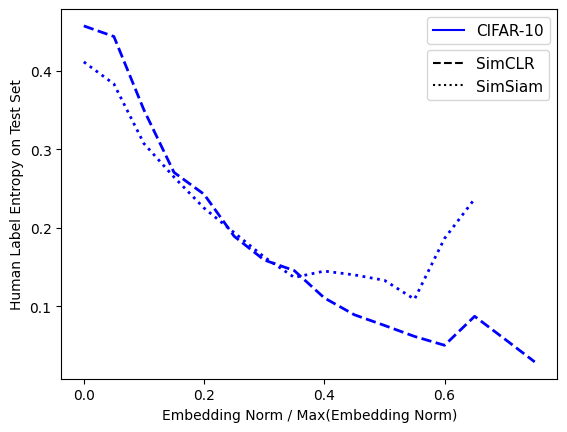

In [195]:
for model_str in ['simclr', 'simsiam']:
    inds = np.where(entropy_counts[model_str] >= 10)[0]
    plt.plot(
        norm_range[inds],
        model_entropies[model_str][inds],
        color=colors['cifar10'],
        linestyle=linestyles[model_str],
        linewidth=2
    )
    # plt.fill_between(
    #     norm_range[inds],
    #     model_entropies[model_str][inds] - model_entr_devs[model_str][inds],
    #     model_entropies[model_str][inds] + model_entr_devs[model_str][inds],
    #     color=colors[dataset],
    #     alpha=0.1
    # )


plt.ylabel('Human Label Entropy on Test Set')
plt.xlabel('Embedding Norm / Max(Embedding Norm)')
plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

dataset_name_dict = {'cifar10': 'CIFAR-10'}
dataset_patches = []
dataset_names = []
for dataset in ['cifar10']:
    dataset_patches.append(plt.plot([], [], color=colors[dataset])[0])
    dataset_names.append(dataset_name_dict[dataset])
model_patches = []
for model_str in ['simclr', 'simsiam']:
    model_patches.append(plt.plot([], [], color='black', linestyle=linestyles[model_str])[0])

dataset_legend = plt.legend(dataset_patches, dataset_names, fontsize=11, loc=1)
plt.legend(model_patches, ['SimCLR', 'SimSiam'], fontsize=11, bbox_to_anchor=(0.699, 0.91, 0.3, 0.), loc='best')
plt.gca().add_artist(dataset_legend)
plt.show()